In [63]:
import json
import re
import numpy as np
from collections import defaultdict

In [60]:
import matplotlib.pyplot as plt

In [30]:
with open('master_results.json') as f:
    master_results = json.load(f)

In [19]:
from copy import deepcopy

In [24]:
master_results_copy = deepcopy(master_results)

In [25]:
for model, model_value in master_results.items():
    for input_size, input_value in model_value['false'].items():
        for hardware, hardware_value in input_value.items():
            for time_type, time_value in hardware_value.items():
                if isinstance(time_value, list):
                    master_results_copy[model]['false'][input_size][hardware][time_type] = {'mean': time_value[0], 'std': time_value[1]}

In [29]:
with open('master_results.json', 'w+') as f:
    json.dump(master_results_copy, f)

In [119]:
with open('cpu_results_updated.json') as f:
    cpu_results = json.load(f)

with open('v100_results.json') as f:
    v100_results = json.load(f)
    
with open('v100_results_optim.json') as f:
    v100_results_optim = json.load(f)

In [122]:
from jsonmerge import merge

In [125]:
master_results_updated = merge(cpu_results, v100_results)
master_results_updated = merge(master_results_updated, v100_results_optim)

In [126]:
with open('master_results_updated.json', 'w+') as f:
    json.dump(master_results_updated, f)

In [342]:
with open('cpu_optim_results.json') as f:
    cpu_optim_results = json.load(f)

In [343]:
master_results_updated_optim = merge(master_results_updated, cpu_optim_results)

In [344]:
with open('master_results_updated_optim.json', 'w+') as f:
    json.dump(master_results_updated_optim, f)

In [233]:
def plot_all_models(results, plotter, title, **kwargs):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.suptitle(title)
    
    models = [['bert-base', 'distilbert'], ['electra-small', 'bert-tiny']]

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            model_name = models[i][j]
            plotter(results[model_name], model_name, col, **kwargs)
    plt.show()

In [362]:
def plot_all_hardware(results, plotter, title, **kwargs):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    fig.suptitle(title)
    
    hardwares = ['local_cpu', 'remote_cpu', 'remote_v100']

    for j, col in enumerate(ax):
        hardware = hardwares[j]
        plotter(results, hardware, col, **kwargs)
    plt.show()

## Effect of Input Size

In [127]:
def analyze_batch_size(model_results):
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
    for input_size, input_value in model_results.items():
        bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
        bs, sl = int(bs), int(sl)
        input_sizes.append(bs * sl)
        for hardware, hardware_value in input_value.items():
            values[hardware].append(hardware_value['total_time']['mean'])
            stddevs[hardware].append(hardware_value['total_time']['std'])
    
    sorted_means = dict()
    sorted_stds = dict()
    for hardware, hardware_value in values.items():
        value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
        value_zip.sort()
        _, sorted_mean, sorted_std = zip(*value_zip)
        sorted_means[hardware] = sorted_mean
        sorted_stds[hardware] = sorted_std
                
    for hardware, hardware_means in sorted_means.items():
        plt.errorbar(sorted(input_sizes), hardware_means, yerr=sorted_stds[hardware])
    plt.legend(values.keys())
    plt.xlabel('Input Size (Batch Size x Sequence Length)')
    plt.ylabel('Total Mean Inference Time (s)')
    plt.show()

In [240]:
def analyze_batch_size_plot(model_results, model_name, plot, onnx_opt='false'):
    results = model_results[onnx_opt]
    
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
    for input_size, input_value in results.items():
        bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
        bs, sl = int(bs), int(sl)
        input_sizes.append(bs * sl)
        for hardware, hardware_value in input_value.items():
            values[hardware].append(hardware_value['total_time']['mean'])
            stddevs[hardware].append(hardware_value['total_time']['std'])
    
    sorted_means = dict()
    sorted_stds = dict()
    for hardware, hardware_value in values.items():
        value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
        value_zip.sort()
        _, sorted_mean, sorted_std = zip(*value_zip)
        sorted_means[hardware] = sorted_mean
        sorted_stds[hardware] = sorted_std
                
    for hardware, hardware_means in sorted_means.items():
        plot.errorbar(sorted(input_sizes), hardware_means, yerr=sorted_stds[hardware])
    plot.legend(values.keys())
    plot.set_xlabel('Input Size (Batch Size x Sequence Length)')
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(model_name)

In [400]:
def analyze_batch_size_by_hardware_plot(master_results, hardware, plot, onnx_opt='false'):
    
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
        
    for model, model_results in master_results.items():
        results = model_results[onnx_opt]
        inp_sizes = []
        for input_size, input_value in results.items():
            bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
            bs, sl = int(bs), int(sl)
            inp_sizes.append(bs * sl)            
            values[model].append(input_value[hardware]['local_time']['mean'])
            stddevs[model].append(input_value[hardware]['local_time']['std'])
            
        input_sizes = inp_sizes

        sorted_means = dict()
        sorted_stds = dict()
        for m, m_value in values.items():
            value_zip = list(zip(input_sizes, m_value, stddevs[m]))
            value_zip.sort()
            _, sorted_mean, sorted_std = zip(*value_zip)
            sorted_means[m] = sorted_mean
            sorted_stds[m] = sorted_std
                
    for model, model_means in sorted_means.items():
        plot.errorbar(sorted(input_sizes), model_means, yerr=sorted_stds[model], color=color_map[model])
    plot.legend(values.keys())
    plot.set_xlabel('Input Size (Batch Size x Sequence Length)')
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(hardware)
    plot.set_yscale('log')
    plot.set_xscale('log')

In [419]:
def analyze_batch_size_opt_by_hardware_plot(master_results, hardware, plot):
    
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
        
    for model, model_results in master_results.items():
        for onnx_opt, results in model_results.items():
            inp_sizes = []
            for input_size, input_value in results.items():
                bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
                bs, sl = int(bs), int(sl)
                inp_sizes.append(bs * sl)            
                values[(model, onnx_opt)].append(input_value[hardware]['local_time']['mean'])
                stddevs[(model, onnx_opt)].append(input_value[hardware]['local_time']['std'])

            input_sizes = inp_sizes

    sorted_means = dict()
    sorted_stds = dict()
    for m, m_value in values.items():
        value_zip = list(zip(input_sizes, m_value, stddevs[m]))
        value_zip.sort()
        _, sorted_mean, sorted_std = zip(*value_zip)
        sorted_means[m] = sorted_mean
        sorted_stds[m] = sorted_std
                
    for model, model_means in sorted_means.items():
        label = f"{model[0]}, {'Vanilla' if model[1] == 'false' else 'Optim'}"
        symbol = 's' if model[1] == 'false' else 'o'
        fillstyle ='full' if model[1] == 'false' else 'none'
        plot.plot(sorted(input_sizes), model_means, color=color_map[model[0]], fillstyle=fillstyle, label=label, marker=symbol)
#     plot.legend(values.keys())
    plot.legend()
    plot.set_xlabel('Input Size (Batch Size x Sequence Length)')
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(hardware)
    plot.set_yscale('log')
    plot.set_xscale('log')

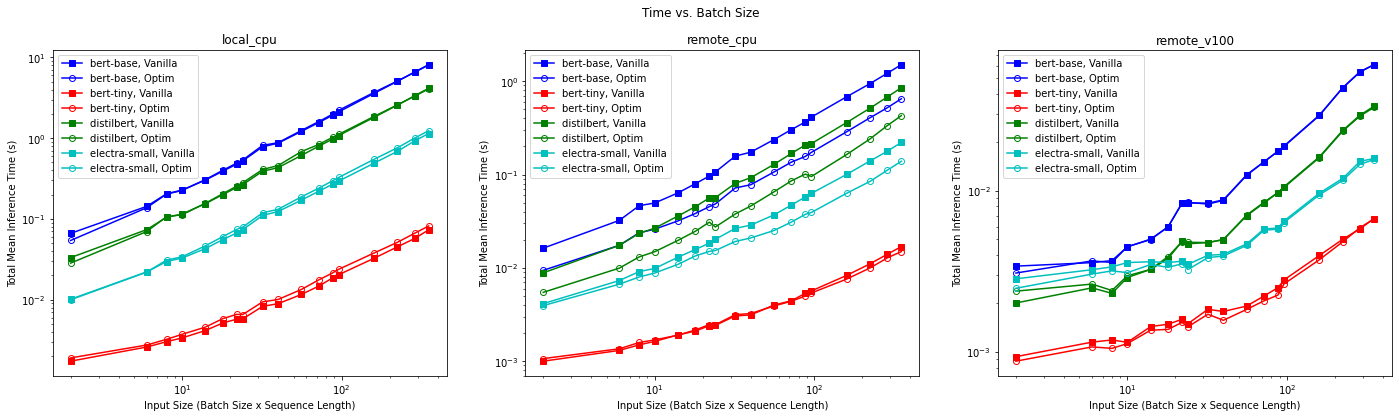

In [420]:
plot_all_hardware(master_results_updated_optim, analyze_batch_size_opt_by_hardware_plot, "Time vs. Batch Size")

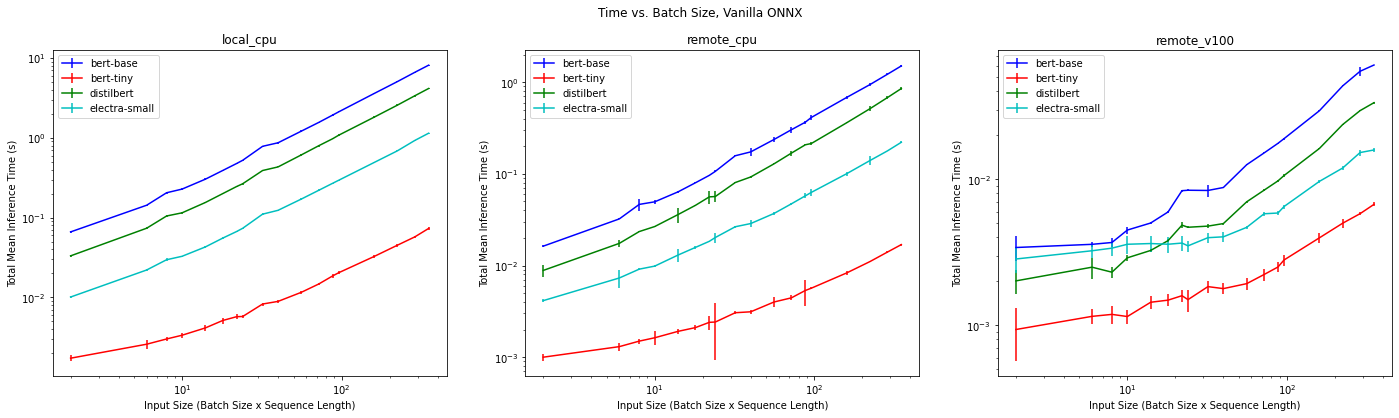

In [401]:
plot_all_hardware(master_results_updated_optim, analyze_batch_size_by_hardware_plot, "Time vs. Batch Size, Vanilla ONNX", onnx_opt='false')

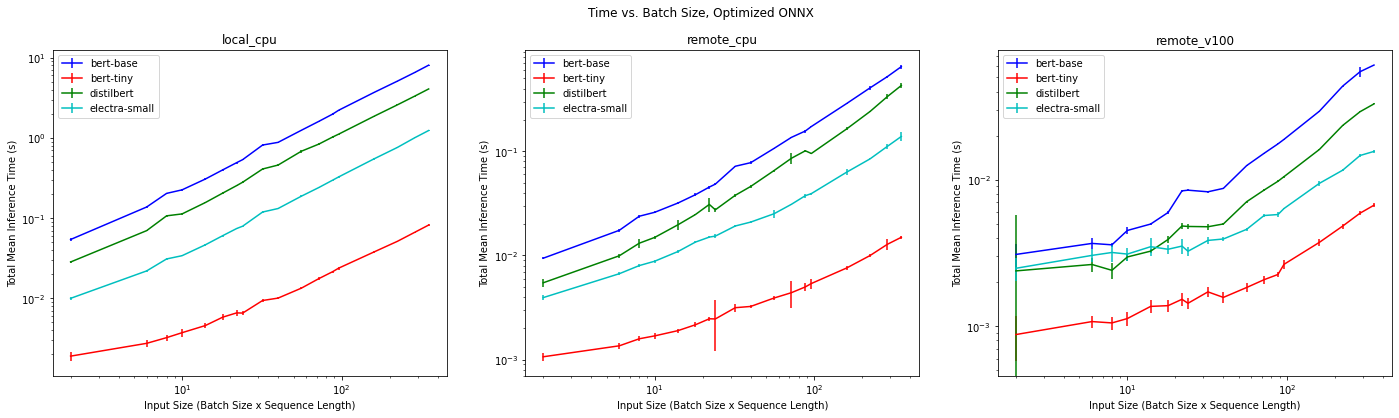

In [402]:
plot_all_hardware(master_results_updated_optim, analyze_batch_size_by_hardware_plot, "Time vs. Batch Size, Optimized ONNX", onnx_opt='true')

In [310]:
color_map = {
        'bert-base': 'b',
        'bert-tiny': 'r',
        'distilbert': 'g',
        'electra-small': 'c'
    }

symbol_map = {
        'local_cpu': 'o',
        'remote_cpu': 's',
        'remote_v100': '^',
    }

In [381]:
def analyze_batch_size_plot_all(master_results, onnx_opt='false'):
    
    plt.figure(figsize=(20,15))
    labels = []
    for model, model_results in master_results.items():
        results = model_results[onnx_opt]

        input_sizes = []
        values = defaultdict(list)
        stddevs = defaultdict(list)
        for input_size, input_value in results.items():
            bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
            bs, sl = int(bs), int(sl)
            input_sizes.append(bs * sl)
            for hardware, hardware_value in input_value.items():
                values[hardware].append(hardware_value['local_time']['mean'])
                stddevs[hardware].append(hardware_value['local_time']['std'])

        sorted_means = dict()
        sorted_stds = dict()
        for hardware, hardware_value in values.items():
            value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
            value_zip.sort()
            _, sorted_mean, sorted_std = zip(*value_zip)
            sorted_means[hardware] = sorted_mean
            sorted_stds[hardware] = sorted_std

        for hardware, hardware_means in sorted_means.items():
            plt.plot(sorted(input_sizes), hardware_means, color=color_map[model], marker=symbol_map[hardware]) #, yerr=sorted_stds[hardware])
            labels.append(f"{model}-{hardware}")
            
    plt.legend(labels)
    plt.xlabel('Input Size (Batch Size x Sequence Length)')
    plt.ylabel('Total Mean Inference Time (s)')
    plt.yscale('log')
    plt.xscale('log')
#     plt.set_title(model_name)
    plt.show()

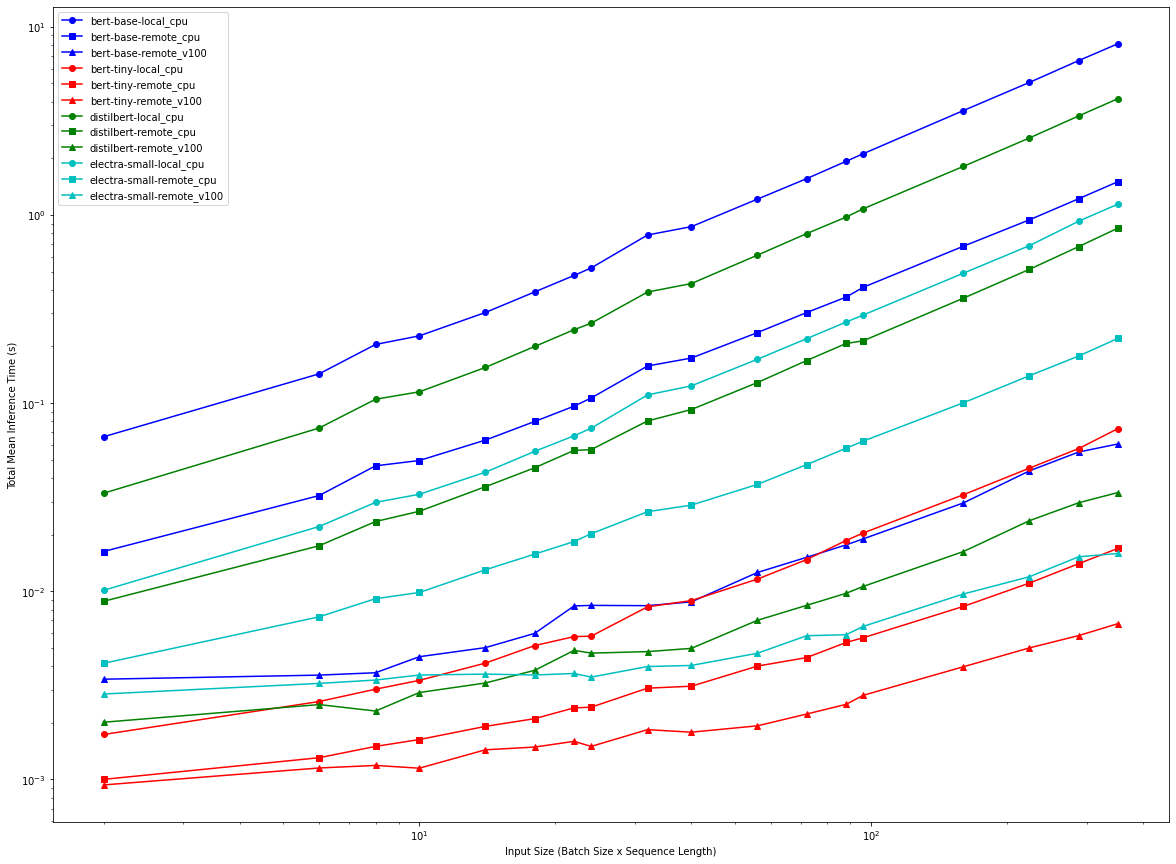

In [382]:
analyze_batch_size_plot_all(master_results_updated_optim, onnx_opt='false')

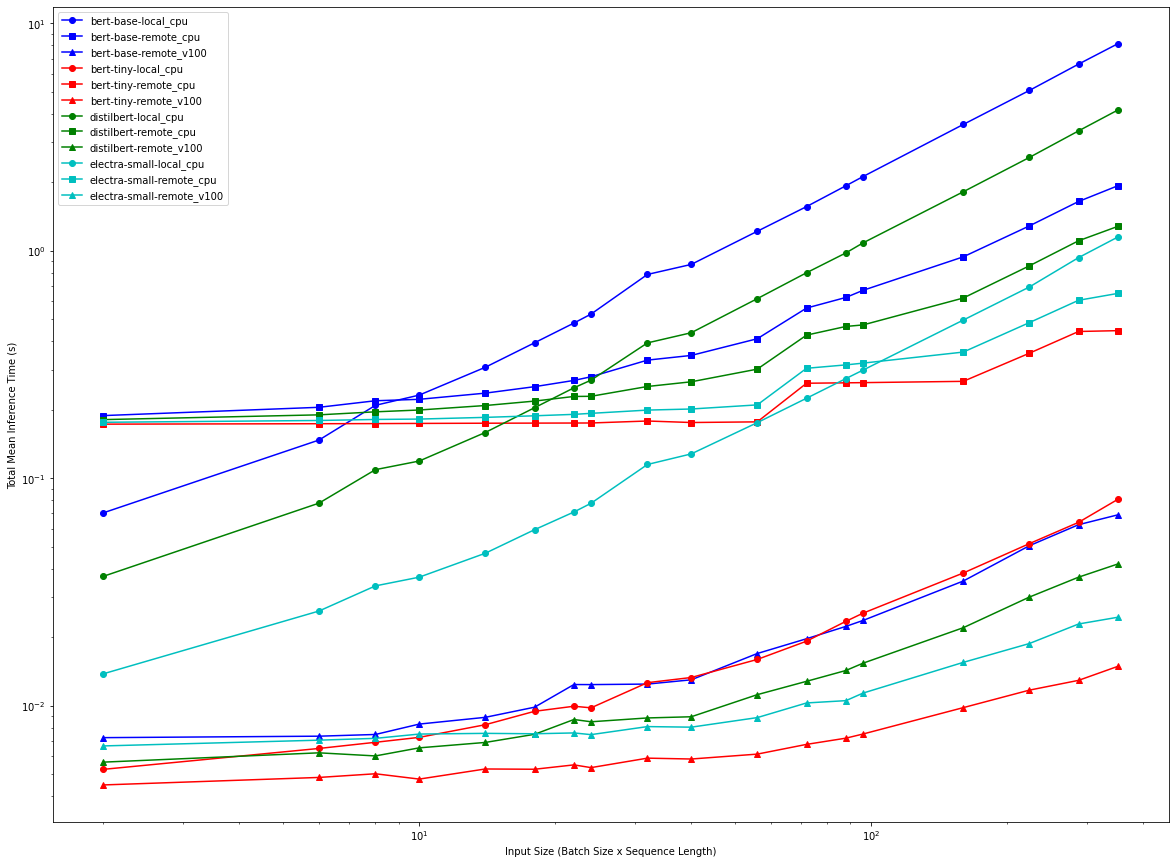

In [379]:
analyze_batch_size_plot_all(master_results_updated_optim, onnx_opt='false')

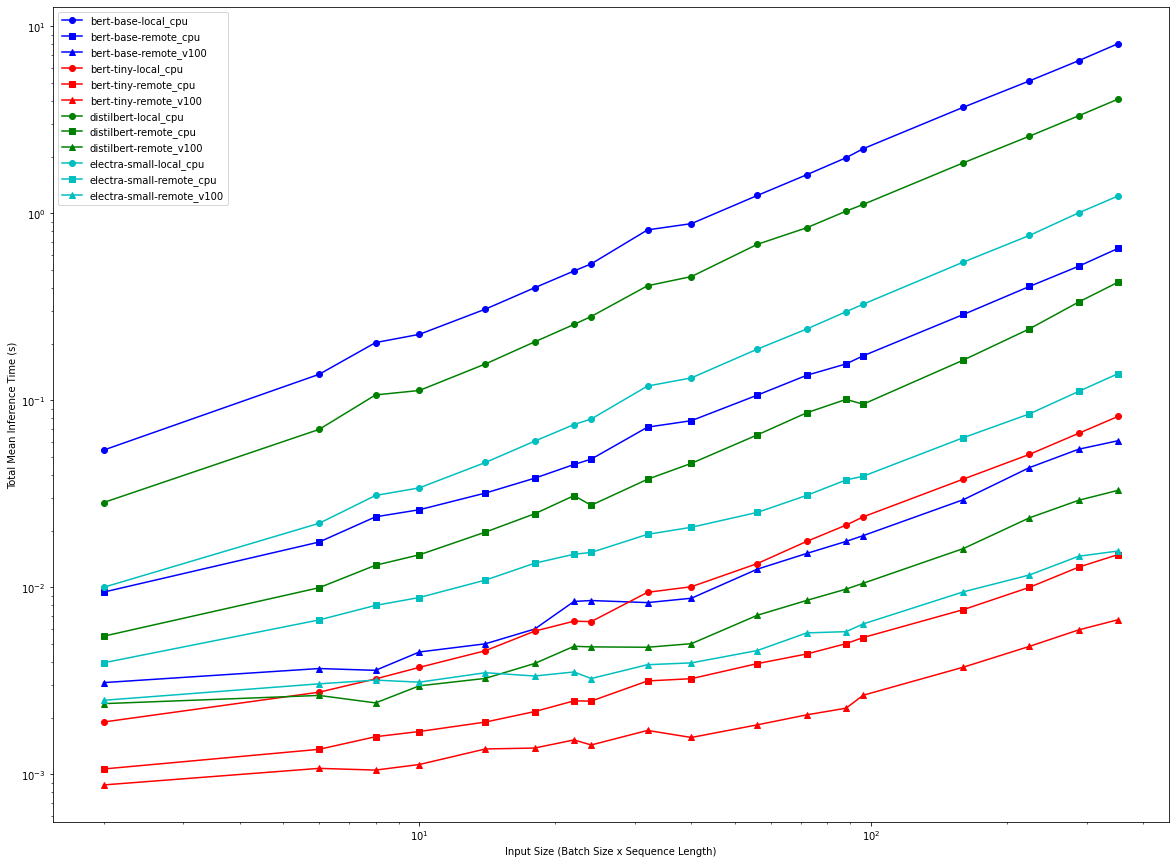

In [385]:
analyze_batch_size_plot_all(master_results_updated_optim, onnx_opt='true')

In [386]:
def plot_at_input_size(master_results, input_size='bs32_sl3', onnx_opt='false'):
    plt.figure(figsize=(20,15))
    colors = []
    
    labels = list(symbol_map.keys())
    x = np.arange(len(labels))
    width = 0.15  # the width of the bars  
    
    values = defaultdict(dict)
    stddevs = defaultdict(dict)
    for model, model_results in master_results.items():
        results = model_results[onnx_opt]

        input_value = results[input_size]
        for hardware, hardware_value in input_value.items():
#             values[f"{model}\n{hardware}"] = hardware_value['total_time']['mean']
#             stddevs[f"{model}\n{hardware}"] = hardware_value['total_time']['std']
            values[model][hardware] = hardware_value['local_time']['mean']
            stddevs[model][hardware] = hardware_value['local_time']['std']
            colors.append(color_map[model])

#         sorted_means = dict()
#         sorted_stds = dict()
#         for hardware, hardware_value in values.items():
#             value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
#             value_zip.sort()
#             _, sorted_mean, sorted_std = zip(*value_zip)
#             sorted_means[hardware] = sorted_mean
#             sorted_stds[hardware] = sorted_std

    

    for i, (model, model_values) in enumerate(values.items()):
        rects = plt.bar(x + (i-1.5)*width, model_values.values(), width, yerr=stddevs[model].values(), color=color_map[model], label=model)
        plt.bar_label(rects, fmt="%.4f", padding=3)
            
    plt.ylabel('Log Total Mean Inference Time (s)')
    plt.xticks(x, labels)
    plt.yscale('log')

    plt.legend()
    plt.show()

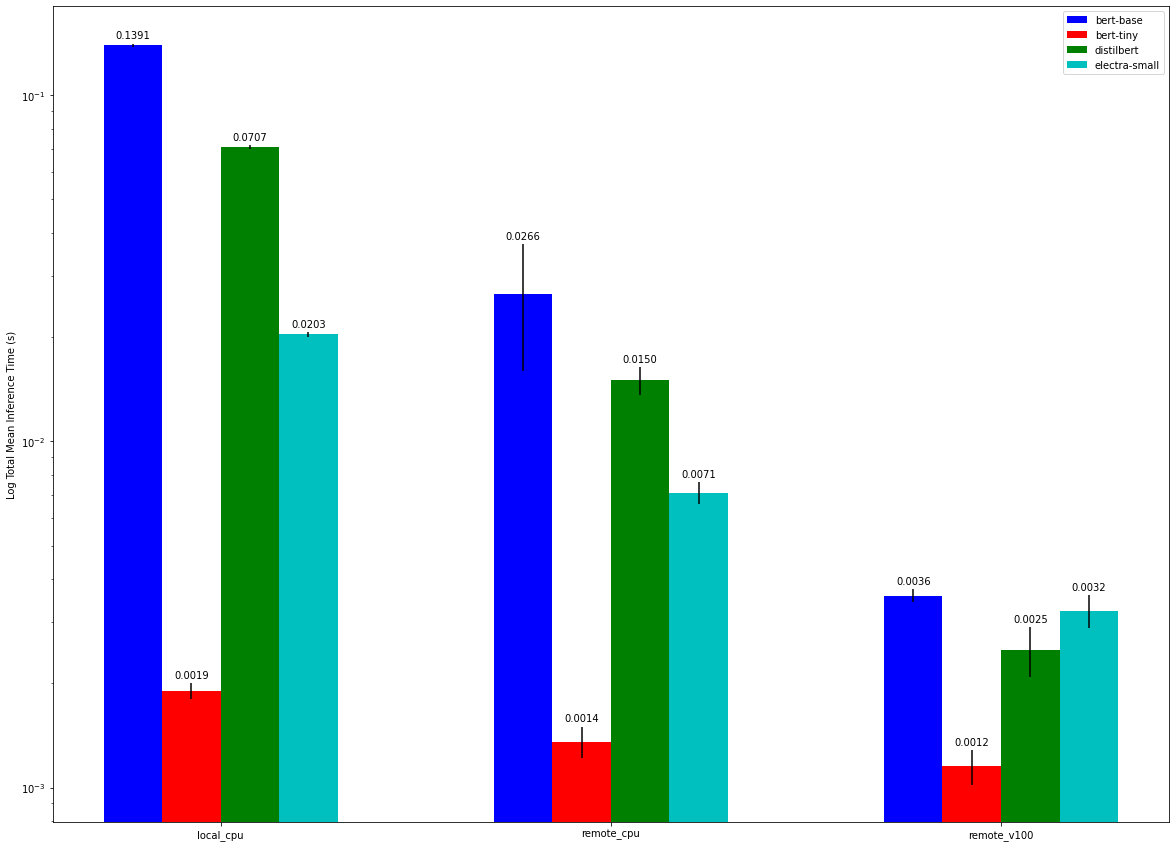

In [387]:
plot_at_input_size(master_results_updated, input_size='bs2_sl3', onnx_opt='false')

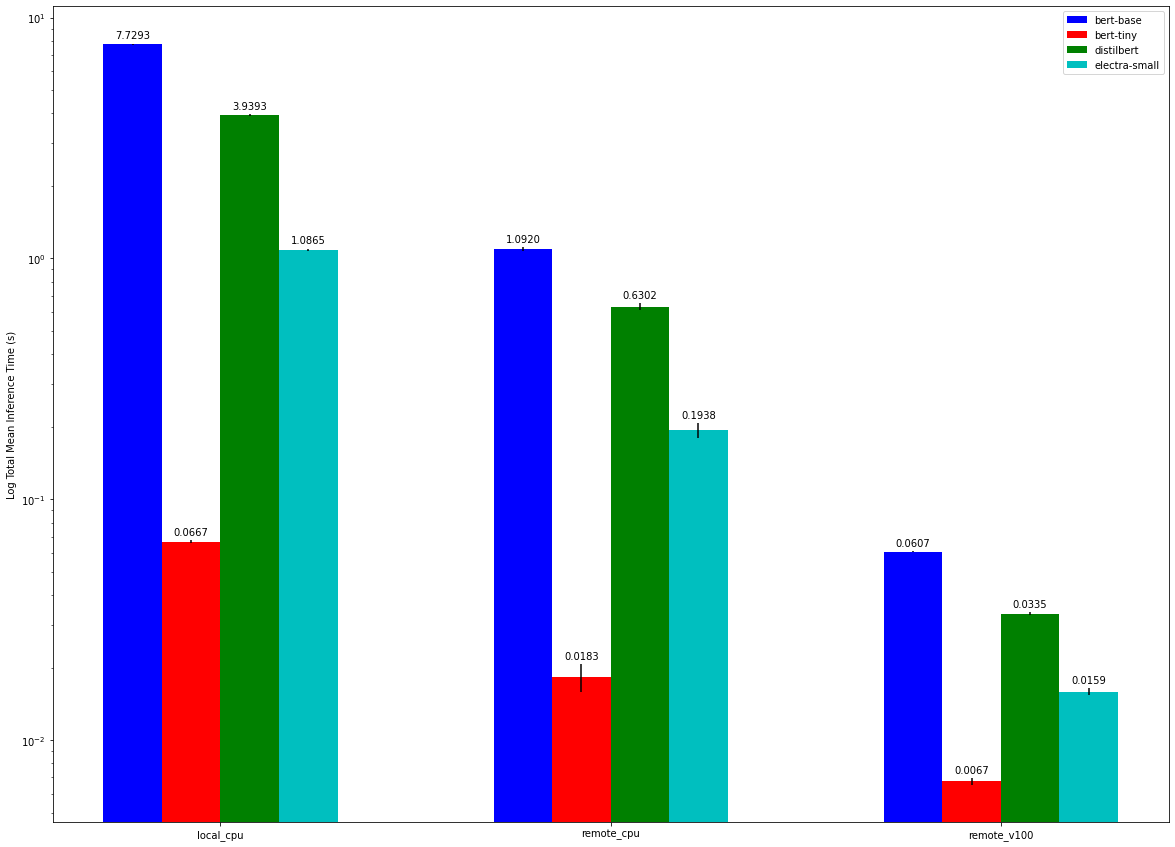

In [388]:
plot_at_input_size(master_results_updated, input_size='bs32_sl11', onnx_opt='false')

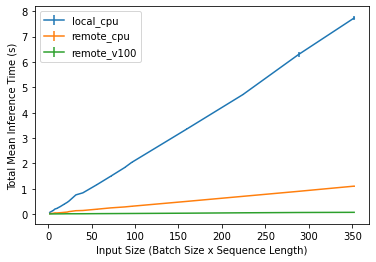

In [128]:
analyze_batch_size(master_results_updated['bert-base']['false'])

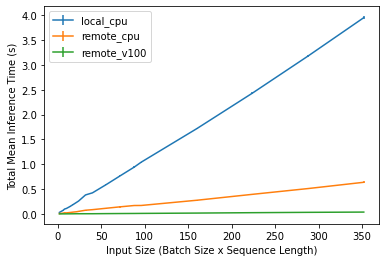

In [129]:
analyze_batch_size(master_results_updated['distilbert']['false'])

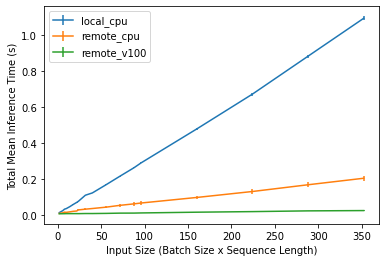

In [130]:
analyze_batch_size(master_results_updated['electra-small']['false'])

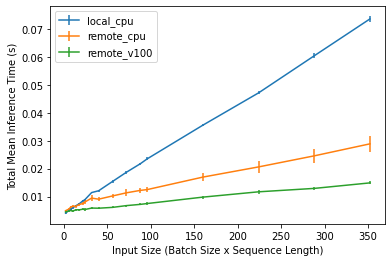

In [131]:
analyze_batch_size(master_results_updated['bert-tiny']['false'])

## ONNX Quantization (CPU) vs. Optimization (GPU)

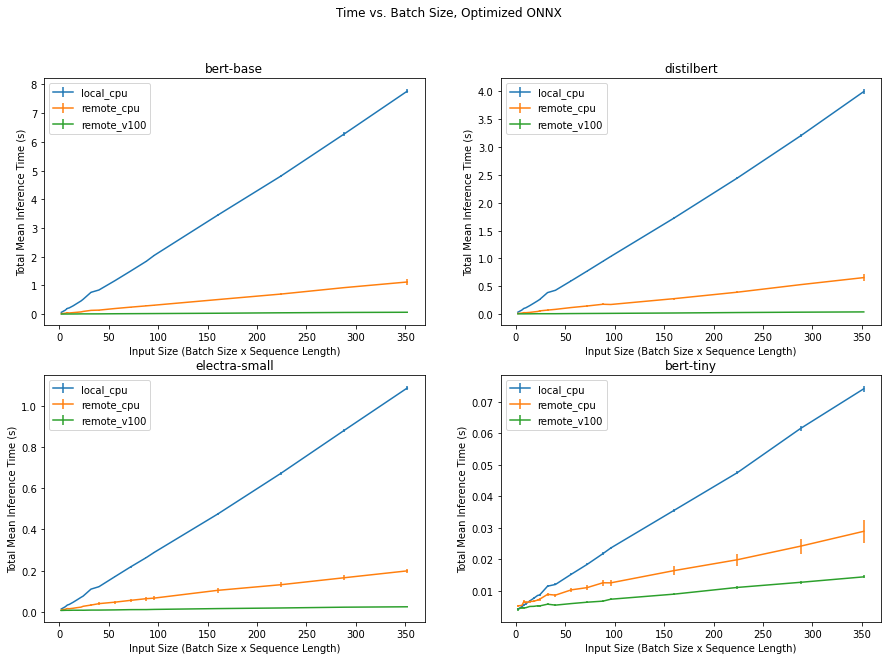

In [236]:
plot_all_models(master_results_updated, analyze_batch_size_plot, "Time vs. Batch Size, Optimized ONNX", onnx_opt='true')

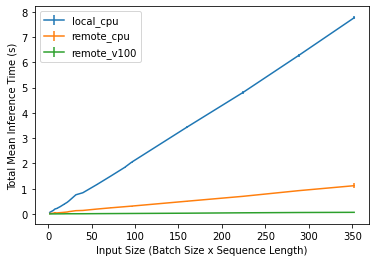

In [132]:
analyze_batch_size(master_results_updated['bert-base']['true'])

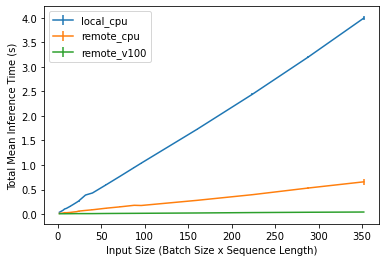

In [133]:
analyze_batch_size(master_results_updated['distilbert']['true'])

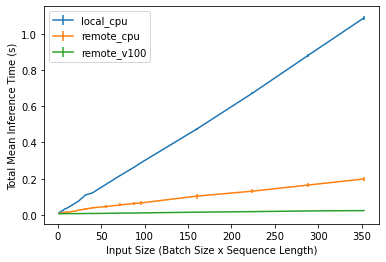

In [134]:
analyze_batch_size(master_results_updated['electra-small']['true'])

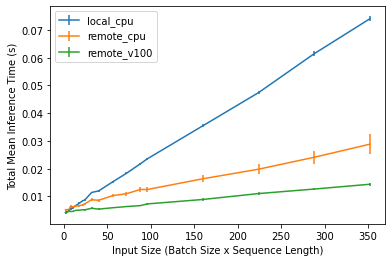

In [135]:
analyze_batch_size(master_results_updated['bert-tiny']['true'])

In [178]:
def analyze_optim(model_results):
    vanilla_values = dict()
    vanilla_std = dict()
    
    optim_values = dict()
    optim_std = dict()
    
    for hardware, hardware_value in model_results['false']['bs32_sl11'].items():
        vanilla_values[hardware] = hardware_value['total_time']['mean']
        vanilla_std[hardware] = hardware_value['total_time']['std']
    for hardware, hardware_value in model_results['true']['bs32_sl11'].items():
        optim_values[hardware] = hardware_value['total_time']['mean']
        optim_std[hardware] = hardware_value['total_time']['std']
    
    labels = list(vanilla_values.keys())
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter("{x:.3f}")
    rects1 = ax.bar(x - width/2, vanilla_values.values(), width, yerr=vanilla_std.values(), label='Vanilla')
    rects2 = ax.bar(x + width/2, optim_values.values(), width, yerr=optim_std.values(), label='Optim')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time (s)')
    ax.set_title('Effect of ONNX Optimization')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, fmt="%.4f", padding=3)
    ax.bar_label(rects2, fmt="%.4f", padding=3)

    fig.tight_layout()
    
    ax.margins(0.1)

    plt.show()

In [220]:
def analyze_optim_plot(model_results, model_name, plot):
    vanilla_values = dict()
    vanilla_std = dict()
    
    optim_values = dict()
    optim_std = dict()
    
    for hardware, hardware_value in model_results['false']['bs32_sl11'].items():
        vanilla_values[hardware] = hardware_value['total_time']['mean']
        vanilla_std[hardware] = hardware_value['total_time']['std']
    for hardware, hardware_value in model_results['true']['bs32_sl11'].items():
        optim_values[hardware] = hardware_value['total_time']['mean']
        optim_std[hardware] = hardware_value['total_time']['std']
    
    labels = list(vanilla_values.keys())
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars

    plot.yaxis.set_major_formatter("{x:.3f}")
    rects1 = plot.bar(x - width/2, vanilla_values.values(), width, yerr=vanilla_std.values(), label='Vanilla')
    rects2 = plot.bar(x + width/2, optim_values.values(), width, yerr=optim_std.values(), label='Optim')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(model_name)
    plot.set_xticks(x, labels)
    plot.legend()

    plot.bar_label(rects1, fmt="%.4f", padding=3)
    plot.bar_label(rects2, fmt="%.4f", padding=3)
    
    plot.margins(0.1)

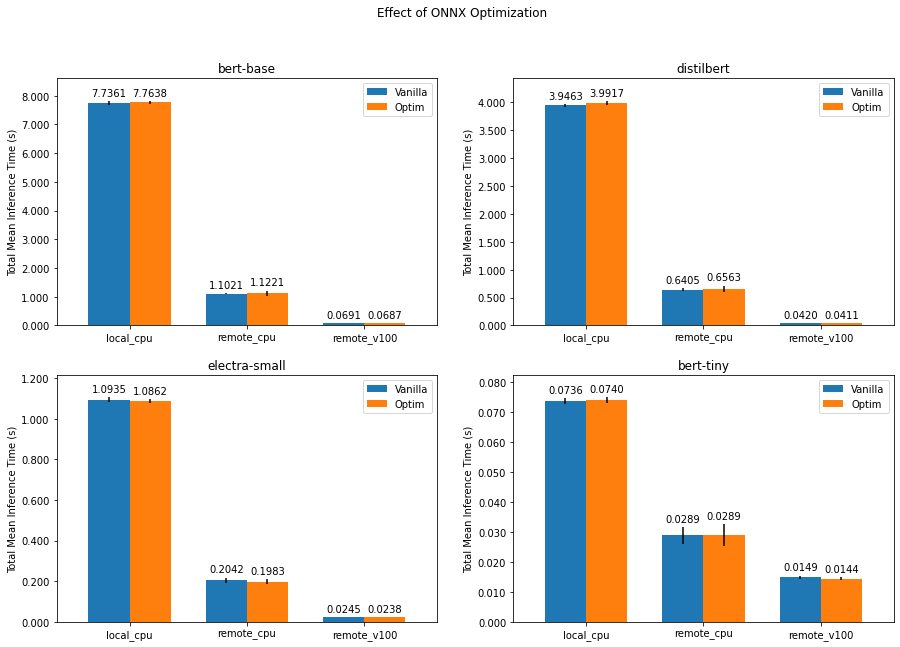

In [237]:
plot_all_models(master_results_updated, analyze_optim_plot, "Effect of ONNX Optimization")

## Speedup

In [422]:
## Plot it/s vs seq_len
data_map = []
for model_type, v1 in master_results_updated_optim.items():
    for quant, v2 in v1.items():
        for bs_seq, v3 in v2.items():
            for execu, v4 in v3.items():
                for time, v5 in v4.items():
                    half = bs_seq.split('_')
                    seq = int(half[1][2:])
                    batch = int(half[0][2:])
                    data_map.append([model_type, quant, batch, seq, execu, time, v5['mean'], v5['std']])
                    
len(data_map)

864

In [423]:
import pandas as pd

df = pd.DataFrame(data_map, columns=['model_type', 'quant', 'batch_size', 'seq_len',
                                     'exec', 'time_type', 'mean', 'std'])
df['seq_len'] = df['seq_len'] * 10 + 2

D:\Programs\Anaconda3\envs\transformers\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


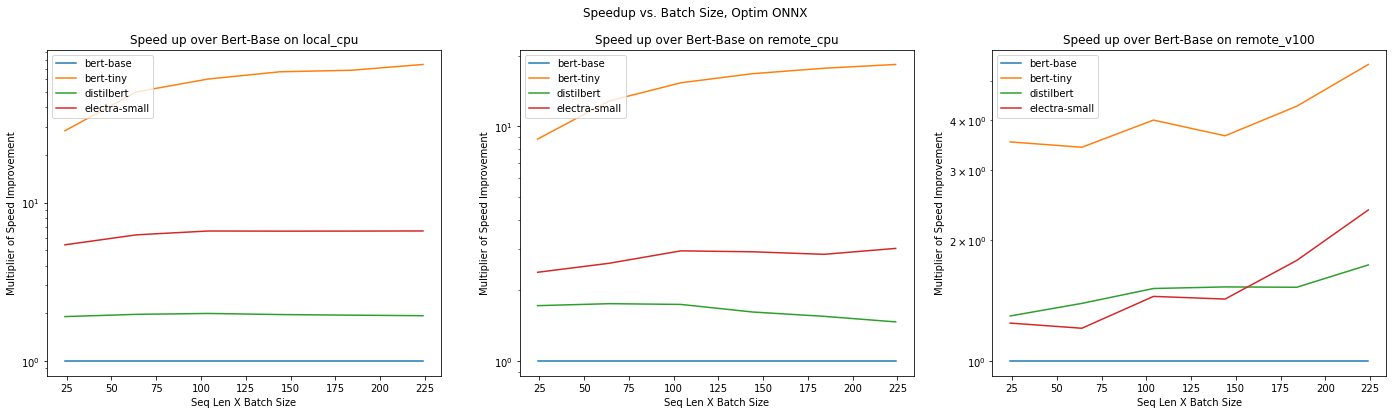

In [424]:
# compute per model speed up

storage = None

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
for i, e_type in enumerate(['local_cpu', 'remote_cpu', 'remote_v100']):
#     fig = plt.figure(figsize=(10,7))
    for ix, model in enumerate(np.unique(df['model_type'])):
        df_m = df.loc[df['model_type'] == model]

        df_m = df_m.loc[df_m['exec'] == e_type]
        df_m = df_m.loc[df_m['time_type'] == 'local_time']
        df_m = df_m.loc[df_m['batch_size'] == 2]
        df_m['flop'] = df_m['batch_size'] * df_m['seq_len']
        df_m['it_s'] = 1 / (df_m['mean'])
        df_m = df_m.loc[df_m['quant'] == 'true']

        if ix == 0:
            storage = np.array(df_m['it_s'])

        ax[i].plot(df_m['flop'], df_m['it_s'] / storage, label=model)
    
    ax[i].legend(loc='upper left')
    ax[i].set_title('Speed up over Bert-Base on '+e_type)
    ax[i].set_yscale('log')
    ax[i].set_ylabel('Multiplier of Speed Improvement')
    ax[i].set_xlabel('Seq Len X Batch Size')
#     fig.show()
fig.suptitle("Speedup vs. Batch Size, Optim ONNX")
fig.show()

In [425]:
from collections import defaultdict

In [426]:
# Get average server response type per type and per model
x = []
for model in np.unique(df['model_type']):
    df_model = df.loc[df['model_type'] == model]
    df_model = df_model.loc[df_model['exec'] == 'remote_cpu']
    aid = df_model.groupby('time_type').mean()
    x.append(aid['mean']['total_time'] - aid['mean']['local_time'])
np.mean(x)

0.229450348979897

D:\Programs\Anaconda3\envs\transformers\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


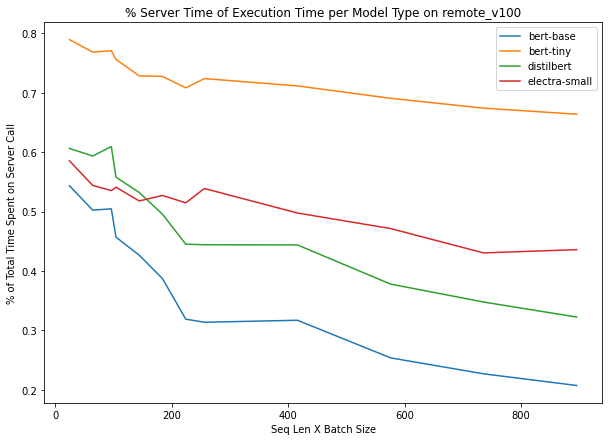

In [427]:
# compute % of time due to server per model type

storage = None

for e_type in ['remote_v100']:#, 'remote_cpu', 'remote_v100']:
    fig = plt.figure(figsize=(10,7))
    for ix, model in enumerate(np.unique(df['model_type'])):
        df_m = df.loc[df['model_type'] == model]
        df_m = df_m.loc[df_m['exec'] == e_type]
        
        
        df_m = df_m.loc[df_m['batch_size'] <= 8]
        df_m_l = df_m.loc[df_m['time_type'] == 'local_time'].reset_index()
        df_m = df_m.loc[df_m['time_type'] == 'total_time'].reset_index()
        df_m['flop'] = df_m['batch_size'] * df_m['seq_len']
#         df_m['perc'] = .005 / df_m['mean']
        df_m['perc'] = (df_m['mean'] - df_m_l['mean']) / df_m['mean']
        df_m = df_m.loc[df_m['quant'] == 'true']
        
        zipped_lists = zip(df_m['flop'], df_m['perc'])
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        df_m['flop'], df_m['perc'] = [ list(tuple) for tuple in  tuples]
        
        plt.plot(df_m['flop'], df_m['perc'], label=model)
    
    plt.legend()
    plt.title('% Server Time of Execution Time per Model Type on '+e_type)
    plt.ylabel('% of Total Time Spent on Server Call')
    plt.xlabel('Seq Len X Batch Size')
    fig.show()